## This code was originally developed by C. Ben Mahmoud and later modified for LDOS training by A. Aryanpour


## In Set A, the Density of States (DOS) is splited into Local Density of States (LDOS) components. The LDOS data is then used to train the LDOS model, following a procedure analogous to that used for DOS training.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ase.io as ase_io
from tqdm.notebook import tnrange
from time import time
import json
import re
from rascal.neighbourlist.structure_manager import (
        mask_center_atoms_by_species, mask_center_atoms_by_id)

from rascal.utils import from_dict, to_dict, CURFilter, dump_obj, load_obj, get_score, print_score, FPSFilter
from rascal.models import Kernel, sparse_points, train_gap_model, KRR, compute_KNM
from rascal.representations import SphericalExpansion, SphericalInvariants as SOAP
from rascal.utils import (get_radial_basis_covariance, get_radial_basis_pca, 
                          get_radial_basis_projections, get_optimal_radial_basis_hypers )
from rascal.utils import radial_basis
from scipy.optimize import minimize, brentq
from scipy.integrate import trapezoid
from scipy.interpolate import interp1d

In [2]:
def gauss(x):
    return np.exp(-0.5*x**2)
############################
def domse(lsigma, delta, KKa, KKb, kMM, sya, syb, ktrain, ytrain, sparse_jitter=1e-12):
    """auxiliary function that computes the errors for a certain regularization
    parameter in fun do_krr """
    sigma = np.exp(lsigma[0])
    nref = len(kMM)
    ska = kMM * delta * sigma**2 + KKa
    skb = kMM * delta * sigma**2 + KKb
    wa = np.linalg.solve(ska + np.eye(nref)*sparse_jitter, sya)
    wb = np.linalg.solve(skb + np.eye(nref)*sparse_jitter, syb)
    pab = np.dot(ktrain[ntrain//2:], wa)
    pba = np.dot(ktrain[:ntrain//2], wb)
    #print(wa.shape,"wa",pab.shape,"pab", pba.shape,"pba",ytrain[ntrain//2:].shape,"ytrain[ntrain//2:]" ,ytrain[:ntrain//2].shape,"ytrain[:ntrain//2]")    
    mse = np.sum((pab-ytrain[ntrain//2:])**2 + (pba-ytrain[:ntrain//2])**2)/ntrain
    return np.log(mse)
##############################
def do_krr(kNM, kMM, itrain, itest, target, s=None, sparse_jitter=1e-12):
    """ performs KRR, if the regularization parameter is provided.
    Otherwise, it finds the optimal parameter using 2-fold cross validation.
    Returns sigma, weights, pred
    sigma is the regularization parameter (or a list of them)"""
    nref = len(kMM)
    y = target
    ktrain = kNM[itrain]
    if (len(y.shape) > 1):
        ytrain = y[itrain] - y[itrain].mean(axis=0)
        print(ytrain.shape,"= ytrain.shape")
    else:
        ytrain = y[itrain] - y[itrain].mean()
        
    if (ytrain.std() != 0):
        delta = np.var(ytrain)/(np.trace(kMM)/nref)
        sya = delta*np.dot(delta*ktrain[:ntrain//2].T,ytrain[:ntrain//2])
        syb = delta*np.dot(delta*ktrain[ntrain//2:].T,ytrain[ntrain//2:])    
        KKa = np.dot(ktrain[:ntrain//2].T,ktrain[:ntrain//2])*delta**2
        KKb = np.dot(ktrain[ntrain//2:].T,ktrain[ntrain//2:])*delta**2
        print(ktrain[:ntrain//2].shape)
        if (s==None):
            rmin = minimize(domse, [np.log(0.01)], (delta, KKa, KKb, kMM, sya, syb, ktrain, ytrain),
                            method = "Nelder-Mead", options={"maxiter":8})
            sigma = np.exp(rmin["x"])[0]
        else:
            sigma = s

        sparseK = kMM * delta * sigma**2 +  np.dot(kNM[itrain].T,kNM[itrain])*delta**2
        sparseY = delta*np.dot(delta*kNM[itrain].T,ytrain)
        w = np.linalg.solve(sparseK + np.eye(nref)*sparse_jitter*delta, sparseY)
    
    else:
        w = 1.0 * np.zeros((nref))
        sigma = 1e3
     
    if (len(y.shape) > 1):
        ypred = np.dot(kNM,w) + y[itrain].mean(axis=0)
    else:
        ypred = np.dot(kNM, w) + y[itrain].mean()
    return sigma, w, ypred

################################
def do_resampling_pw(ntot, kNM, kMM, itrain, itest, target, sigma, sparse_jitter=1e-12):
    """ performs an error estimation using resampling/bootstrapping.
    VERY SPECIFIC TO THE PW REPRESENATION OF DOS/DOS AS A SINGLE PROPERTY.
    weights is an array of zeros!!! (TODO)
    returns: yrs, weights, alpha"""
    y = target - target[itrain].mean(axis=0)
    nref = len(kMM)
    delta = np.var(y[itrain])/(np.trace(kMM)/nref)
    print (delta)
    ypred = np.zeros((nrs, target.shape[0], target.shape[1]))
    irs = np.zeros((nrs, ntrs), int)
    weights = np.zeros((nrs, nref))
    for j in range(nrs):
        irs[j] = np.random.choice(itrain, ntrs, replace=False)
        sparseK = kMM * delta * sigma**2 +  np.dot(kNM[irs[j]].T,kNM[irs[j]])*delta**2
        sparseY = delta*np.dot(delta*kNM[irs[j]].T,y[irs[j]])
        w = np.linalg.solve(sparseK + np.eye(nref)*sparse_jitter*delta, sparseY)
        ypred[j] = np.dot(kNM,w) 
    
    alpha = np.zeros(target.shape[1])
    print (alpha.shape)
    yrs = np.zeros(ypred.shape)
    
    for i in range(target.shape[1]):
        rsy = np.zeros(ntot); rsy2 = np.zeros(ntot); rsny = np.zeros(ntot, int);
        for j in range(nrs):
            rstest = np.setdiff1d(itrain, irs[j])
            rsy[rstest]  += ypred[j,rstest, i]
            rsy2[rstest] += ypred[j,rstest, i]**2
            rsny[rstest] += 1
        selstat = np.where(rsny>4)[0]
        ybest = rsy[selstat]/rsny[selstat]
        yerr = np.sqrt(rsy2[selstat]/rsny[selstat] - (rsy[selstat]/rsny[selstat])**2)
        try:
            alpha[i] = np.sqrt(np.mean((ybest - y[selstat, i])**2/yerr**2))
        except:
            print ('there is a problem with index {}'.format(i))
        yrs[:, :, i] = np.mean(ypred[:, :, i],axis=0) + alpha[i]* (ypred[:, :, i]- np.mean(ypred[:, :, i],axis=0))
    yrs +=  target[itrain].mean(axis=0)
    print ('yrs shape is = ', yrs.shape)
    return yrs, weights, alpha
##################################
def get_dos_rmse(a, b, xdos, perc=False):
    """ computes  Root Mean Squared Error (RMSE) of array properties (DOS/aofd).
         a=pred, b=target, xdos, perc: if False return RMSE else return %RMSE"""
    rmse = np.sqrt(trapezoid((a - b)**2, xdos, axis=1).mean())
    if not perc:
        return rmse
    else:
        mean = b.mean(axis=0)
        std = np.sqrt(trapezoid((b - mean)**2, xdos, axis=1).mean())
        return 100 * rmse / std
##################################
def extract_frame_from_xyz(filename, frame_index, output_filename):
    """
    Extracts a specific frame from an .xyz file and saves it to a new file.

    Args:
    filename (str): The path to the input .xyz file.
    frame_index (int): The index of the frame to extract (1-based index).
    output_filename (str): The path to the output .xyz file.
    """
    with open(filename, 'r') as file:
        current_frame = 1
        while True:
            header = file.readline()
            if not header:
                break  # End of file
            num_atoms = int(header.strip())
            title = file.readline()  # The second line of each frame
            
            # Read the atom data for the frame
            atoms = []
            for _ in range(num_atoms):
                atoms.append(file.readline())
                
            if current_frame == frame_index:
                # Write the current frame to the output file if it matches the frame_index
                with open(output_filename, 'w') as output_file:
                    output_file.write(header)  # Number of atoms
                    output_file.write(title)  # Lattice vectors and other descriptions
                    output_file.writelines(atoms)  # Atomic data
                print(f"Frame {frame_index} has been extracted to {output_filename}.")
                break  # Exit after writing the desired frame
            
            # Increment the frame counter
            current_frame += 1
###############################
def KNM_ldos(frames_all, X_sparse_features, nenv_all):
    zeta = 2
    managers = soap.transform(frames_all)
    features = managers.get_features(soap)
    #get kMM
    kMM = (X_sparse_features @ X_sparse_features.T)**zeta
    # get kNM 
    kNM = np.zeros((nenv_all, nref))
    kNM = (features @ X_sparse_features.T)**zeta
    return kNM, kMM
################################
def KNM_DOS(frames_test, natoms_test, X_sparse_features):
    managers_test = soap.transform(frames_test)
    features_test = managers_test.get_features(soap)
    kMM_test = (X_sparse_features @ X_sparse_features.T)**zeta
    kNM_test = np.zeros((len(frames_test), nref))
    k = 0
    for i in range(len(frames_test)):
        ifeatures = features_test[k: k+natoms_test[i]]
        k += natoms_test[i]
        kNM_test[i] = ((ifeatures @ X_sparse_features.T)**zeta).sum(axis=0)
        kNM_test[i] /= natoms_test[i]

    return kNM_test, kMM_test


## Loading Data

In [3]:
# Path to binary file
file_path = "data/dos_ref_A.bin"

# Load as 1D array
data = np.fromfile(file_path, dtype=np.float64)  # Use the dtype you saved with

# Reshape to original dimensions
dos_ref_A = data.reshape((1039, 389))

print(dos_ref_A.shape)  # (1039, 389)


(1039, 389)


In [8]:
# Path to binary file
file_path = "data/ldos_ref.bin"
# Load as 1D array
data = np.fromfile(file_path, dtype=np.float16)  # Use the dtype you saved with

# Reshape to original dimensions
ldos_ref_A = data.reshape((29723, 389))

print(ldos_ref_A.shape) 


(29723, 389)


In [5]:
xdos = np.loadtxt("data/xdos.txt")

## Training DOS

In [6]:
prefix = "Silicon"

HYPERS = {
    'soap_type': 'PowerSpectrum',
    'interaction_cutoff': 6.,
    'max_radial': 12,
    'max_angular': 9,
    'gaussian_sigma_constant': 0.45,
    'gaussian_sigma_type': 'Constant',
    'cutoff_smooth_width': 0.45,
    'radial_basis': 'GTO',
    'normalize' : True,
    'cutoff_function_type': 'RadialScaling',
    'cutoff_function_parameters': {'rate': 1.,
        'scale': 3.,
        'exponent': 5,
        'interaction_cutoff': 6.,
        'cutoff_smooth_width': 0.45},
}
################################## load frames from input file "traininig_dataset.xyz"
frames = ase_io.read("data/traininig_dataset.xyz", ":")
##########################
for frame in frames:
    frame.wrap(eps=1e-12)
########################## make ntot
ntot = len(frames)
########################## make number of atoms of every frame
natoms = np.zeros(ntot, dtype=int)
for i in range(ntot):
    natoms[i] = len(frames[i])
########################## definition of number of train and test frames using its numbers
np.random.seed(1234)
ntrain = 800
itrain = np.arange(ntot)
np.random.shuffle(itrain)
itest = itrain[ntrain:]
itrain = itrain[:ntrain]
######################### definition of number of sparse environments and atomic number and zeta
nref = 2000
n_sparse = {14: nref}
######################### 
zeta = 2
######################### make features and sparse them as "X_sparse_features"
soap = SOAP(**HYPERS)
sparse = FPSFilter(soap, n_sparse, act_on='sample per species')
start = time()
managers = soap.transform(frames)
X_sparse = sparse.select_and_filter(managers)

features = managers.get_features(soap)
X_sparse_features = X_sparse._sparse_points.get_features()
######################### detrmination kMM
## get kMM
kMM = (X_sparse_features @ X_sparse_features.T)**zeta
######################### detrminate kNM
## get kNM
kNM = np.zeros((ntot, nref))

k = 0
for i in tnrange(ntot):
    ifeatures = features[k: k+natoms[i]]
    k += natoms[i]
    kNM[i] = ((ifeatures @ X_sparse_features.T)**zeta).sum(axis=0)
    kNM[i] /= natoms[i]

###################### calculate ML-DOS weights 
sigma_dos , weights_dos, dos_pred = do_krr(kNM, kMM, itrain, itest, dos_ref_A)
print ("Total Execution time: ", time()-start ,"s")


  0%|          | 0/1039 [00:00<?, ?it/s]

(800, 389) = ytrain.shape
(400, 2000)
Total Execution time:  18.834048986434937 s


## Training LDOS

In [7]:
nenv = len(ldos_ref_A)
np.random.seed(1234)
ntrain = int(0.8*nenv)
itrain = np.arange(nenv)
np.random.shuffle(itrain)
itest = itrain[ntrain:]
itrain = itrain[:ntrain]

nref_ldos = 2000
n_sparse = {14: nref_ldos}
#########################
zeta = 2
#########################
soap = SOAP(**HYPERS)
sparse = FPSFilter(soap, n_sparse, act_on='sample per species')
start = time()
managers = soap.transform(frames)
X_sparse = sparse.select_and_filter(managers)

features_ldos = managers.get_features(soap)
X_sparse_features_ldos = X_sparse._sparse_points.get_features()
#########################
## get kMM
kMM_ldos = (X_sparse_features_ldos @ X_sparse_features_ldos.T)**zeta
#########################
## get kNM
kNM_ldos = np.zeros((nenv, nref_ldos))

kNM_ldos = (features_ldos @ X_sparse_features_ldos.T)**zeta

#########################

sigma_ldos, weights_ldos, ldos_pred = do_krr(kNM_ldos, kMM_ldos, itrain, itest, ldos_ref_A)
######################
k = 0
dos_ldos_pred = np.zeros((ntot, len(xdos)))
for i in range(ntot):
    dos_ldos_pred[i] = np.mean(ldos_pred[k:k+natoms[i]], axis=0)
    k += natoms[i]

print ("Total Execution time: ", time()-start, "s")


(23778, 389) = ytrain.shape
(11889, 2000)
Total Execution time:  36.30240201950073 s


In [12]:
X_sparse_features_ldos.shape, weights_ldos.shape

((2000, 1440), (2000, 389))

In [13]:
binary_file_path = "/Users/aryan/Documents/thesis/second_work/codes_and_data/X_sparse_features_ldos.bin"

# Save as raw binary (use float32 for minimal size)
X_sparse_features_ldos.astype(np.float16).tofile(binary_file_path)

print(f"Data saved as binary to: {binary_file_path}")

binary_file_path = "/Users/aryan/Documents/thesis/second_work/codes_and_data/weights_ldos.bin"

# Save as raw binary (use float32 for minimal size)
weights_ldos.astype(np.float16).tofile(binary_file_path)

print(f"Data saved as binary to: {binary_file_path}")


Data saved as binary to: /Users/aryan/Documents/thesis/second_work/codes_and_data/X_sparse_features_ldos.bin
Data saved as binary to: /Users/aryan/Documents/thesis/second_work/codes_and_data/weights_ldos.bin


In [8]:

## Error of DOS and LDOS training in Percent
get_dos_rmse(ldos_ref_A, ldos_pred, xdos, perc=True), get_dos_rmse(dos_pred, dos_ref_A, xdos, perc=True)


(0.32924867235365046, 6.186534083664153)

## Splitting Set A to randomly distinct Train and Test sets

In [9]:
import numpy as np
import random

# -------------------------
# Paths
# -------------------------
xyz_file = "data/traininig_dataset.xyz"

frames_train_file = "frames_train.xyz"
frames_test_file = "frames_test.xyz"
ldos_train_file = "ldos_train.npy"
ldos_test_file = "ldos_test.npy"

# -------------------------
# Load data
# -------------------------
ldos = ldos_ref_A # shape: (29723, 389)
nframes = len(natoms)

# -------------------------
# Select random test indices
# -------------------------
test_indices = sorted(random.sample(range(nframes), 200))
train_indices = [i for i in range(nframes) if i not in test_indices]

# -------------------------
# Read XYZ frames into memory
# -------------------------
with open(xyz_file, "r") as f:
    lines = f.readlines()

frames = []
idx = 0
for i in range(nframes):
    n = natoms[i]
    frames.append(lines[idx:idx + n + 2])  # 2 header lines
    idx += n + 2

# -------------------------
# Save XYZ train/test
# -------------------------
with open(frames_train_file, "w") as f_train, open(frames_test_file, "w") as f_test:
    for i in train_indices:
        f_train.writelines(frames[i])
    for i in test_indices:
        f_test.writelines(frames[i])

# -------------------------
# Split LDOS according to natoms
# -------------------------
ldos_train = []
ldos_test = []

start = 0
for i in range(nframes):
    n = natoms[i]
    frame_ldos = ldos[start:start + n, :]
    if i in train_indices:
        ldos_train.append(frame_ldos)
    else:
        ldos_test.append(frame_ldos)
    start += n

# Concatenate and save
ldos_train = np.vstack(ldos_train)
ldos_test = np.vstack(ldos_test)

np.save(ldos_train_file, np.round(ldos_train, 6))  # Round to 6 decimals
np.save(ldos_test_file, np.round(ldos_test, 6))

print("✅ Done!")
print(f"Train frames: {len(train_indices)}, Test frames: {len(test_indices)}")
print(f"LDOS train shape: {ldos_train.shape}, LDOS test shape: {ldos_test.shape}")


✅ Done!
Train frames: 839, Test frames: 200
LDOS train shape: (24092, 389), LDOS test shape: (5631, 389)


/Users/aryan/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)


## Train on created Train set

In [11]:
frames_train = ase_io.read("frames_train.xyz", ":")
##########################
for frame in frames_train:
    frame.wrap(eps=1e-12)
########################## make ntot
ntot_train = len(frames_train)
########################## make number of atoms of every frame
natoms_train = np.zeros(ntot_train, dtype=int)
for i in range(ntot_train):
    natoms_train[i] = len(frames_train[i])


nenv_train = len(ldos_train)
np.random.seed(1234)
ntrain = int(0.77*nenv_train)
itrain = np.arange(nenv_train)
np.random.shuffle(itrain)
itest = itrain[ntrain:]
itrain = itrain[:ntrain]

nref_ldos = 2000
n_sparse = {14: nref_ldos}
#########################
zeta = 2
#########################
soap = SOAP(**HYPERS)
sparse = FPSFilter(soap, n_sparse, act_on='sample per species')
start = time()
managers = soap.transform(frames_train)
X_sparse = sparse.select_and_filter(managers)

features_ldos = managers.get_features(soap)
X_sparse_features_ldos = X_sparse._sparse_points.get_features()
#########################
## get kMM
kMM_ldos = (X_sparse_features_ldos @ X_sparse_features_ldos.T)**zeta
#########################
## get kNM
kNM_ldos = np.zeros((nenv_train, nref_ldos))

kNM_ldos = (features_ldos @ X_sparse_features_ldos.T)**zeta

#########################

sigma_ldos, weights_ldos, ldos_pred = do_krr(kNM_ldos, kMM_ldos, itrain, itest, ldos_train)
######################
k = 0
dos_ldos_pred = np.zeros((ntot_train, len(xdos)))
for i in range(ntot_train):
    dos_ldos_pred[i] = np.mean(ldos_pred[k:k+natoms_train[i]], axis=0)
    k += natoms_train[i]

print ("Total Execution time: ", time()-start, "s")


(18550, 389) = ytrain.shape
(9275, 2000)
Total Execution time:  29.352537155151367 s


In [78]:
frames_train = ase_io.read("frames_train.xyz", ":")
##########################
for frame in frames_train:
    frame.wrap(eps=1e-12)
########################## make ntot
ntot_train = len(frames_train)
########################## make number of atoms of every frame
natoms_train = np.zeros(ntot_train, dtype=int)
for i in range(ntot_train):
    natoms_train[i] = len(frames_train[i])

# nenv_train = len(dos_train)
np.random.seed(1234)
ntrain = int(0.77*ntot_train)
itrain = np.arange(ntot_train)
np.random.shuffle(itrain)
itest = itrain[ntrain:]
itrain = itrain[:ntrain]

nref_dos = 2000
n_sparse = {14: nref_dos}
#########################
zeta = 2
#########################
soap = SOAP(**HYPERS)
sparse = FPSFilter(soap, n_sparse, act_on='sample per species')
start = time()
managers = soap.transform(frames_train)
X_sparse = sparse.select_and_filter(managers)

features_dos = managers.get_features(soap)
X_sparse_features_dos = X_sparse._sparse_points.get_features()
#########################
## get kMM
kMM_dos = (X_sparse_features_dos @ X_sparse_features_dos.T)**zeta
#########################
## get kNM
kNM_dos = np.zeros((ntot_train, nref_dos))

kNM_dos = (features_dos @ X_sparse_features_dos.T)**zeta

#########################

sigma_dos, weights_dos, dos_pred = do_krr(kNM_dos, kMM_dos, itrain, itest, dos_train)
######################
print ("Total Execution time: ", time()-start, "s")


(646, 389) = ytrain.shape
(323, 2000)
Total Execution time:  13.684859037399292 s


## Prediction Process

In [65]:
dos_train = dos_ref_A[train_indices]
dos_test = dos_ref_A[test_indices]

In [66]:
dos_train.shape, dos_test.shape

((839, 389), (200, 389))

In [12]:
frames_test = ase_io.read("frames_test.xyz", ":")
##########################
for frame in frames_test:
    frame.wrap(eps=1e-12)
########################## make ntot
ntot_test = len(frames_test)
########################## make number of atoms of every frame
natoms_test = np.zeros(ntot_test, dtype=int)
for i in range(ntot_test):
    natoms_test[i] = len(frames_test[i])
nenv_test = np.sum(natoms_test)

In [13]:
kNM_test, kMM_test = KNM_ldos(frames_test, X_sparse_features_ldos, nenv_test)
########################################
mean_pw = ldos_train[itrain].mean(axis=0)
ldos_test_pred = kNM_test @ weights_ldos + mean_pw

In [14]:
get_dos_rmse(ldos_test_pred, ldos_test, xdos, perc=True)

0.10323438489121162

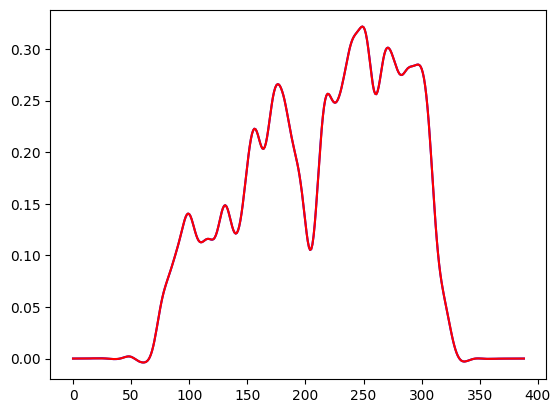

In [16]:
plt.plot(ldos_test_pred[-1], "b")
plt.plot(ldos_test[-1], "r")

## You can compute DOS prediction Using above codes

## It means the LDOS Training is more accurate than DOS Training